# Keras Functional API

## Classify images with a toy ResNet

In this notebook, we will train a reduced version of the popular ResNet neural network, which uses residual connections, to classify images from the CIFAR10 dataset. The notebook is based on the public tutorial found here: https://www.tensorflow.org/guide/keras/functional

##### Import the required modules

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

2022-10-31 18:55:15.647530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 18:55:15.805705: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-31 18:55:15.811227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-31 18:55:15.811245: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

##### Download the CIFAR10 Dataset

As in the previous notebook, will use the `keras.datasets` package to download the dataset. We will also do some (manual) normalization of the data. Notice that it's actually better to use a `Normalization()` Keras layer, so that the input pipeline remains part of your model (more portable). But this will do for a simple example.

The `to_categorical` method applies one-hot encoding to the integer class labels. 

In [2]:
(x_train, y_train_int), (x_test, y_test_int) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train_int, 10)
y_test = keras.utils.to_categorical(y_test_int, 10)

170498071/170498071 [==============================] - 2s 0us/step



CIFAR10 contains 32x32 color images, so the shape of `x_train` and `x_test` is $(n_{images}, 32, 32, 3)$, whereas the shape of `y_train` and `y_test` is $(n_{images}, 10)$ because of the one-hot encoding.

In [3]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 10)


5000 images, size 32x32 each with 3 channels (RGB)

In [4]:
print(y_train[0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


Let us define the class names (they are not defined in the dataset)

In [5]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

Finally, let us plot some images as an example. Wow, the resolution is quite low...!

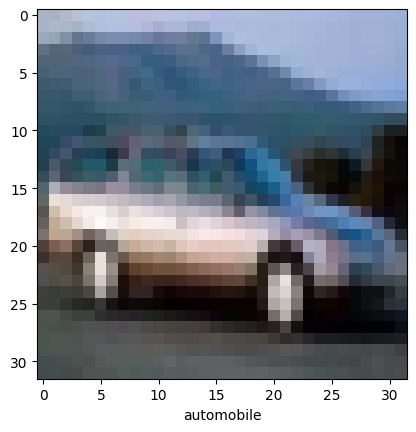

In [6]:
idx = 4
plt.figure()
plt.imshow(x_train[idx])
plt.xlabel(class_names[y_train_int[idx][0]])
plt.grid(False)
plt.show()

##### Let us build a small ResNet-like CNN model with the Functional API

In doing this, we are also seing some new important layers, such as `Input`, `Conv2D`, `MaxPooling2D`, `Dropout`, `add` (element-wise addition), etc. 

- The `Conv2D` layer takes as mandatory parameters the number of output channels and the kernel size. Optional parameters include the stride, the activation function, the padding type, etc.
- The `MaxPooling2D` layer takes as mandatory parameter the pool size. Optional parameters include the stride (defaults to `pool_size`), the padding type, etc.
- The `Dropout` layer takes as mandatory parameter the dropout rate.
- The `add` layer does not have parameters.


Notice that since the `add` layers take two inputs from different parts of the network, this model could not be defined using the Sequential API.

Notice the final `keras.Model` call which specifies the inputs and outputs of our model's graph.

In `Conv2D`, `same` results in padding with zeros evenly to the left/right or up/down of the input. When `padding="same"` and `strides=1`, the output has the same size as the input. (Credits: Keras documentation)

In [6]:
inputs = keras.Input(shape=(32, 32, 3), name="img")
x = keras.layers.Conv2D(32, 3, activation="relu")(inputs)
x = keras.layers.Conv2D(64, 3, activation="relu")(x)
block_1_output = keras.layers.MaxPooling2D(3)(x)

x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_1_output)
x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_2_output = keras.layers.add([x, block_1_output])

x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(block_2_output)
x = keras.layers.Conv2D(64, 3, activation="relu", padding="same")(x)
block_3_output = keras.layers.add([x, block_2_output])

x = keras.layers.Conv2D(64, 3, activation="relu")(block_3_output)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)

# Finally, we need to have 10 classes
outputs = keras.layers.Dense(10)(x)

model = keras.Model(inputs, outputs, name="toy_resnet")

Let us show a summary of the model and plot it.

In [8]:
model.summary()

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, 30, 30, 32)   896         ['img[0][0]']                    
                                                                                                  
 conv2d_8 (Conv2D)              (None, 28, 28, 64)   18496       ['conv2d_7[0][0]']               
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 9, 9, 64)    0           ['conv2d_8[0][0]']               
                                                                                         

In [9]:
keras.utils.plot_model(model, 'toy_resnet.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


##### Compile the model

Let us now compile the model, specifying optimizer, loss function and metrics.

Notice that, differently from the previous notebook, we use `RMSprop` instead of `Adam` this time. We also use the `CategoricalCrossentropy` loss (not the "sparse" variant) since we have generated 1-hot labels, and we use the `from_logits` option because the last layer of the model does not include a softmax activation. Using `from_logits` is normally more stable from a numerical point of view, so it's suggested.


In [10]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

##### Train the model

Notice the new option `validation_split=0.2`. More details on this later.

In [11]:
model.fit(x_train, y_train,
          batch_size=64,
          epochs=10,
          validation_split=0.2
         )

Epoch 1/10
625/625 [==============================] - 129s 204ms/step - loss: 1.8992 - accuracy: 0.2761 - val_loss: 1.5092 - val_accuracy: 0.4201
Epoch 2/10
625/625 [==============================] - 126s 201ms/step - loss: 1.4655 - accuracy: 0.4605 - val_loss: 1.3073 - val_accuracy: 0.5245
Epoch 3/10
625/625 [==============================] - 125s 201ms/step - loss: 1.2317 - accuracy: 0.5571 - val_loss: 1.1298 - val_accuracy: 0.5979
Epoch 4/10
625/625 [==============================] - 125s 200ms/step - loss: 1.0663 - accuracy: 0.6222 - val_loss: 0.9298 - val_accuracy: 0.6680
Epoch 5/10
625/625 [==============================] - 125s 200ms/step - loss: 0.9395 - accuracy: 0.6680 - val_loss: 0.8659 - val_accuracy: 0.6900
Epoch 6/10
625/625 [==============================] - 125s 201ms/step - loss: 0.8578 - accuracy: 0.7028 - val_loss: 0.7943 - val_accuracy: 0.7248
Epoch 7/10
625/625 [==============================] - 125s 200ms/step - loss: 0.7901 - accuracy: 0.7267 - val_loss: 0.8498 -

##### Evaluate on unseen data

Let us test the model on unseen data using the `evaluate()` method. The model is slightly over-fitting the training data.

In [12]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 8s - loss: 0.6931 - accuracy: 0.7646 - 8s/epoch - 26ms/step

Test accuracy: 0.7645999789237976


##### Perform a prediction on a single image

Let us run a prediction on one image and see the result. Notice that some bars in the bar chart are negative this time because we have logits, not probabilities.

1/1 [==============================] - 0s 124ms/step
Predicted label: 3 (cat)
Real label: 3 (cat)


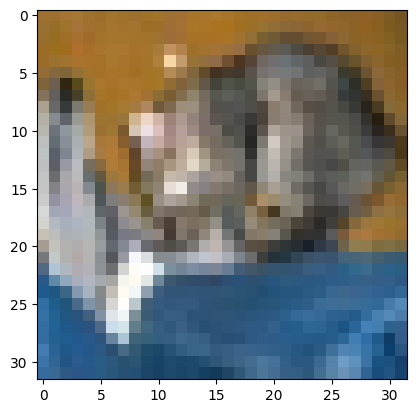

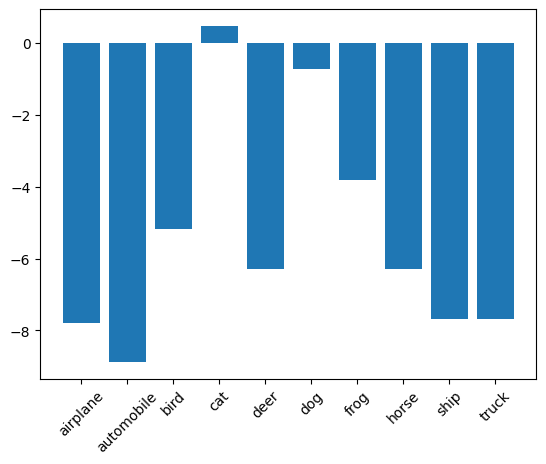

In [13]:
idx = 0
#idx = 7

pred = model.predict(x_test[idx].reshape(1, 32, 32, 3))
pred_lidx = tf.argmax(pred[0])
pred_label = class_names[pred_lidx]

print("Predicted label: {} ({})".format(pred_lidx, pred_label))
print("Real label: {} ({})".format(y_test_int[idx][0], class_names[y_test_int[idx][0]]))

plt.figure()
plt.imshow(x_test[idx])
plt.grid(False)
plt.figure()
plt.bar(range(len(class_names)), pred[0], tick_label=class_names)
plt.xticks(rotation=45)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7817b2ad-42a3-441f-8072-b020be286d3c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>